In [1]:
%matplotlib inline
import inspect, os, sys, copy, pytz, re, glob
import simplejson as json
import pandas as pd
from dateutil import parser
import datetime
import matplotlib.pyplot as plt   # Matplotlib for plotting
import matplotlib.dates as md
import numpy as np
import seaborn as sns
from collections import Counter, defaultdict
utc=pytz.UTC

ENV = "production"
os.environ['CS_ENV'] = 'production'
BASE_DIR = "/home/reddit/CivilServant"
sys.path.append(BASE_DIR)

with open(os.path.join(BASE_DIR, "config") + "/{env}.json".format(env=ENV), "r") as config:
  DBCONFIG = json.loads(config.read())

### LOAD SQLALCHEMY
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text

db_engine = create_engine("mysql://{user}:{password}@{host}/{database}".format(
    host = DBCONFIG['host'],
    user = DBCONFIG['user'],
    password = DBCONFIG['password'],
    database = DBCONFIG['database']))
DBSession = sessionmaker(bind=db_engine)

### LOAD PRAW
import reddit.connection
conn = reddit.connection.Connect(base_dir=BASE_DIR, env="jupyter")

### FILTER OUT DEPRECATION WARNINGS ASSOCIATED WITH DECORATORS
# https://github.com/ipython/ipython/issues/9242
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')

### Goals of this notebook
The goal of this notebook is to conduct an analysis of the post rates for tabloids on r/worldnews before and after the experiment

In [2]:
### CONNECT TO PRAW
r = conn.connect(controller="ModLog")

Version 3.5.0 of praw is outdated. Version 4.4.0 was released Tuesday February 21, 2017.


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json
POST: https://api.reddit.com/api/v1/access_token/
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json


### Create a Dataset of Posts from Worldnews in the Observation Period

In [3]:
all_posts = {}
for row in db_engine.execute(text("select * from posts WHERE subreddit_id = '2qh13' AND created_at >= '2016-11-11' ORDER BY posts.created ASC;")):
    post = {}
    post_data = json.loads(row['post_data'])
    for key in post_data.keys():
        post[key] = post_data[key]
    for key in row.keys():
        post[key]=row[key]
    del post['post_data']
    post['visible']=True

    all_posts[post['id']] = post

In [4]:
tabloid_domains = [ 'dailymail.co.uk', 'express.co.uk','mirror.co.uk', 'news.com.au', 
                    'nypost.com', 'thesun.co.uk','dailystar.co.uk','metro.co.uk']
msm_domains     = [ "bbc.com", "reuters.com", "nytimes.com", "washingtonpost.com", "cnn.com", 
                    "telegraph.co.uk", "latimes.com", "huffingtonpost.com", "theguardian.com", "forbes.com",
                    "examiner.com", "usatoday.com", "wsj.com", "cbsnews.com", "cbc.ca", "time.com",
                    "sfgate.com", "newsweek.com", "bostonglobe.com", "nydailynews.com", "msnbc.com",
                    "foxnews.com", "aljazeera.com", "nbcnews.com", "npr.org", "bloomberg.com", "abcnews.com", 
                    "aljazeera.com", "bigstory.ap.com", "cbc.ca", "time.com"]

### Get Information on Experiment

In [5]:
experiment = {}
for row in db_engine.execute(text("select name, created_at, id FROM experiments WHERE name='sticky_comment_multiarm_worldnews_0';")):
    for key in row.keys():
        experiment[key] = row[key]

earliest_date = sorted([x['created_at'] for x in list(all_posts.values())])[0]
latest_date = sorted([x['created_at'] for x in list(all_posts.values())], reverse=True)[0]
experiment_date = experiment['created_at']

print("Earliest Date: {0}".format(earliest_date))
print("Experiment Date: {0}".format(experiment['created_at']))
print("Latest Date: {0}".format(latest_date))

Earliest Date: 2016-11-11 00:13:19
Experiment Date: 2016-11-27 16:42:19
Latest Date: 2017-04-10 00:25:14


### Collect Information on Moderation Actions (to label visibility of posts)

In [6]:
recent_mod_actions = []
for row in db_engine.execute(text('select action_data from mod_actions WHERE subreddit_id="2qh13" AND created_utc >= "{0}" ORDER BY created_utc;'.format(earliest_date))):
#for row in db_engine.execute(text('select action_data from mod_actions WHERE subreddit_id="2qh13" ORDER BY created_utc;'.format(earliest_date))):
    mod_action = json.loads(row['action_data'])
    mod_action['created'] = utc.localize(datetime.datetime.utcfromtimestamp(mod_action['created_utc']))
    recent_mod_actions.append(mod_action)
print("{0} moderator actions loaded".format(len(recent_mod_actions)))

409402 moderator actions loaded


In [7]:
#Counter([x['created'].date() for x in recent_mod_actions if x['action'] =="removelink"])
#Counter([x['created'].date() for x in recent_mod_actions if x['action'] =="approvelink"])
#recent_mod_actions[0]
sorted(list(all_posts.values()), key=lambda x: x['created'])[500]['created']

datetime.datetime(2016, 11, 12, 17, 37, 34)

### Add Moderation Actions to Posts

In [8]:
missing_mod_actions = []
matched_mod_actions = 0
for action in recent_mod_actions:
    if action['action'] == "removelink":
        key = action['target_fullname'].replace("t3_","")
        if key in all_posts.keys():
            all_posts[key]['visible'] = False
            matched_mod_actions += 1
        else:
            missing_mod_actions.append(key)
    elif action['action'] == 'approvelink':
        key = action['target_fullname'].replace("t3_","")
        if key in all_posts.keys():
            all_posts[key]['visible'] = True
            matched_mod_actions += 1
        else:
            missing_mod_actions.append(key)
#print("Missing Mod Actions: {0}".format(len(missing_mod_actions)))
#print("Missing Mod Action Posts: {0}".format(len(set(missing_mod_actions))))
print("Matched Mod Actions: {0}".format(matched_mod_actions))

Matched Mod Actions: 36089


### Create bins of tabloids and MSM per day

In [9]:
min_day = 0#earliest_date.timetuple().tm_yday
max_day = (latest_date - earliest_date).days
exp_day = (experiment['created_at'] - earliest_date).days

def daydict():
    return {"day":None, "msm":0, "tabloid":0, 
            "total":0, "after_experiment":0,
            "tabloid_removed":0,
            "tabloid_retained":0,
            "total_removed": 0,
            "total_retained": 0,
            "total_domain":defaultdict(int)}

post_days = defaultdict(daydict)

for post in all_posts.values():
    day = (post['created_at'] - earliest_date).days
    post_days[day]['total'] += 1
    post_days[day]['day'] = day
    
    if(post['visible']==False):
        post_days[day]['total_removed'] += 1
    else:
        post_days[day]['total_retained'] += 1
    
    if(post['domain'] in tabloid_domains):
        post_days[day]['tabloid'] += 1
        if(post['visible']==False):
            post_days[day]['tabloid_removed'] += 1
        else:
            post_days[day]['tabloid_retained'] += 1

        post_days[day]['total_domain'][post['domain']] += 1    
    if(post['domain'] in msm_domains):
        post_days[day]['msm'] += 1
    if day == exp_day:
        post_days[day]['after_experiment'] = None
    elif day > exp_day - min_day:
        post_days[day]['after_experiment'] = 1
    
del post_days[max_day-min_day]
day_df = pd.DataFrame(list(post_days.values()))

In [10]:
exp_day

16

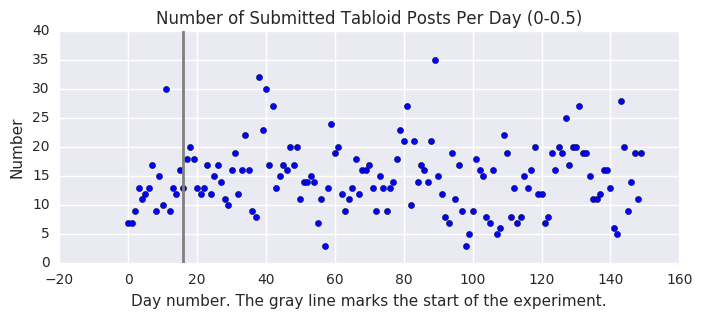

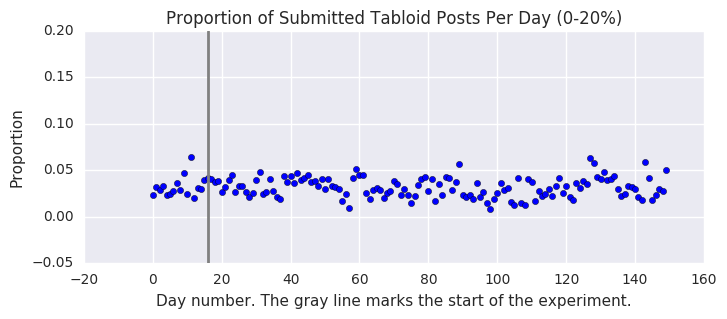

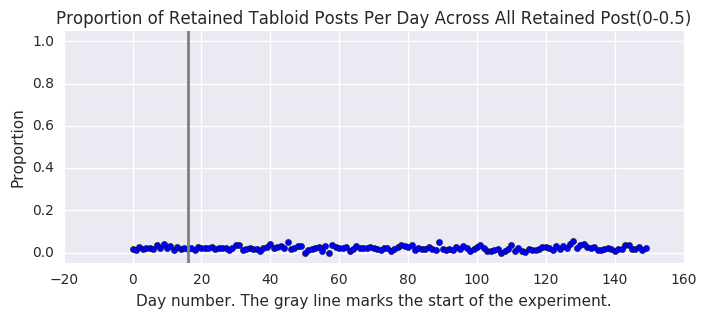

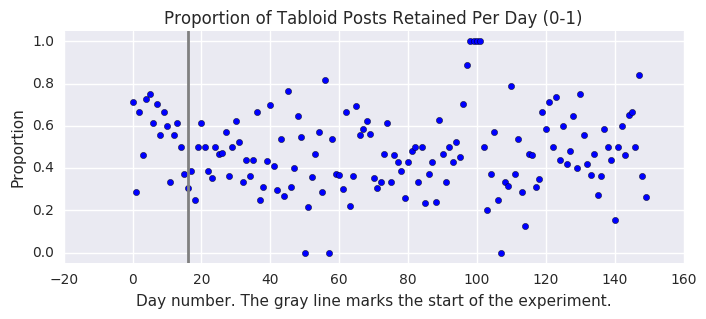

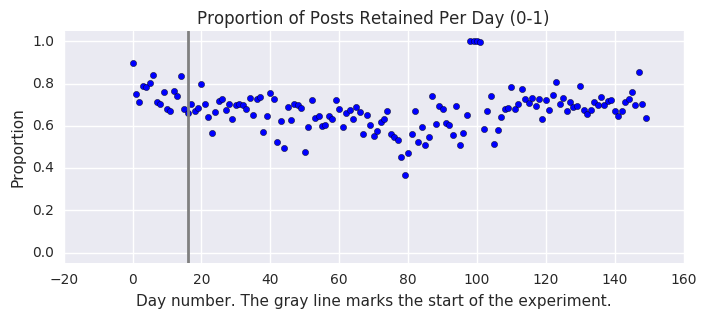

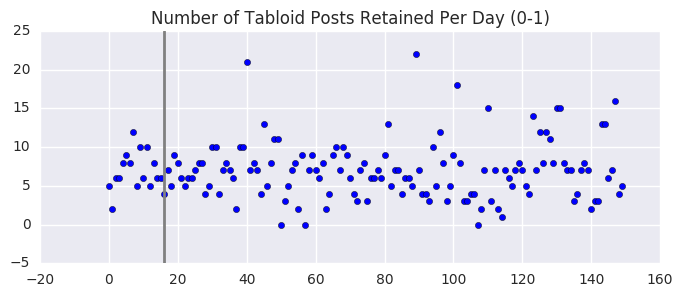

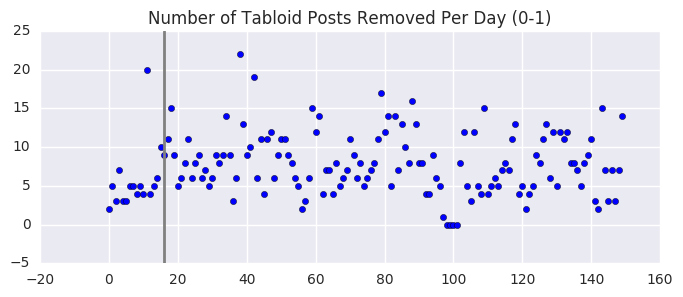

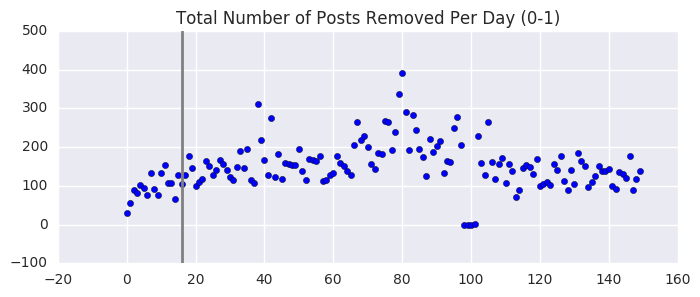

In [19]:
day_df['tabloid_pct'] = day_df.tabloid / day_df.total

day_df['tabloid_kept'] = day_df.tabloid_retained / day_df.tabloid

day_df['tabloid_removed_pct'] = day_df.tabloid_removed / day_df.total_removed

day_df['tabloid_kept_pct'] = day_df.tabloid_retained / day_df.total_retained

day_df['total_kept_pct'] = day_df.total_retained / day_df.total

plt.figure(figsize=(8,3))
plt.axvline(x=exp_day-min_day, ymin=0, ymax = 1, linewidth=2, color='grey')
plt.scatter(day_df.day, day_df.tabloid)
plt.title("Number of Submitted Tabloid Posts Per Day (0-0.5)")
plt.ylabel("Number")
plt.xlabel("Day number. The gray line marks the start of the experiment.")
plt.show()

plt.figure(figsize=(8,3))
plt.axvline(x=exp_day-min_day, ymin=0, ymax = 1, linewidth=2, color='grey')
plt.scatter(day_df.day, day_df.tabloid_pct)
plt.title("Proportion of Submitted Tabloid Posts Per Day (0-20%)")
plt.ylabel("Proportion")
plt.xlabel("Day number. The gray line marks the start of the experiment.")
#plt.xlim((-5,90))
plt.ylim((-0.05,0.2))
plt.show()

plt.figure(figsize=(8,3))
plt.axvline(x=exp_day-min_day, ymin=0, ymax = 1, linewidth=2, color='grey')
plt.scatter(day_df.day, day_df.tabloid_kept_pct)
plt.title("Proportion of Retained Tabloid Posts Per Day Across All Retained Post(0-0.5)")
plt.ylabel("Proportion")
plt.xlabel("Day number. The gray line marks the start of the experiment.")
#plt.xlim((-5,90))
plt.ylim((-0.05,1.05))
plt.show()

plt.figure(figsize=(8,3))
plt.axvline(x=exp_day-min_day, ymin=0, ymax = 1, linewidth=2, color='grey')
plt.scatter(day_df.day, day_df.tabloid_kept)
plt.title("Proportion of Tabloid Posts Retained Per Day (0-1)")
plt.ylabel("Proportion")
plt.xlabel("Day number. The gray line marks the start of the experiment.")
#plt.xlim((-5,90))
plt.ylim((-0.05,1.05))
plt.show()

plt.figure(figsize=(8,3))
plt.axvline(x=exp_day-min_day, ymin=0, ymax = 1, linewidth=2, color='grey')
plt.scatter(day_df.day, day_df.total_kept_pct)
plt.title("Proportion of Posts Retained Per Day (0-1)")
plt.ylabel("Proportion")
plt.xlabel("Day number. The gray line marks the start of the experiment.")
#plt.xlim((-5,90))
plt.ylim((-0.05,1.05))
plt.show()

plt.figure(figsize=(8,3))
plt.axvline(x=exp_day-min_day, ymin=0, ymax = 1, linewidth=2, color='grey')
plt.scatter(day_df.day, day_df.tabloid_retained)
plt.title("Number of Tabloid Posts Retained Per Day (0-1)")
plt.show()

plt.figure(figsize=(8,3))
plt.axvline(x=exp_day-min_day, ymin=0, ymax = 1, linewidth=2, color='grey')
plt.scatter(day_df.day, day_df.tabloid_removed)
plt.title("Number of Tabloid Posts Removed Per Day (0-1)")
plt.show()

plt.figure(figsize=(8,3))
plt.axvline(x=exp_day-min_day, ymin=0, ymax = 1, linewidth=2, color='grey')
plt.scatter(day_df.day, day_df.total_removed)
plt.title("Total Number of Posts Removed Per Day (0-1)")
plt.show()

# plt.axvline(x=exp_day-min_day, ymin=0, ymax = 1, linewidth=2, color='grey')
# plt.scatter(day_df.day, day_df.tabloid_removed_pct)
# plt.title("Tabloid Posts As A Proportion of all Removed Posts Per Day (0-1)")
# plt.show()

In [13]:
#day_df.to_csv(os.path.join("outputs","r_worldnews_posts_per_day-01.19.2017.csv"))

### Investigate Period of No Removals

### Investigate Individual Publications

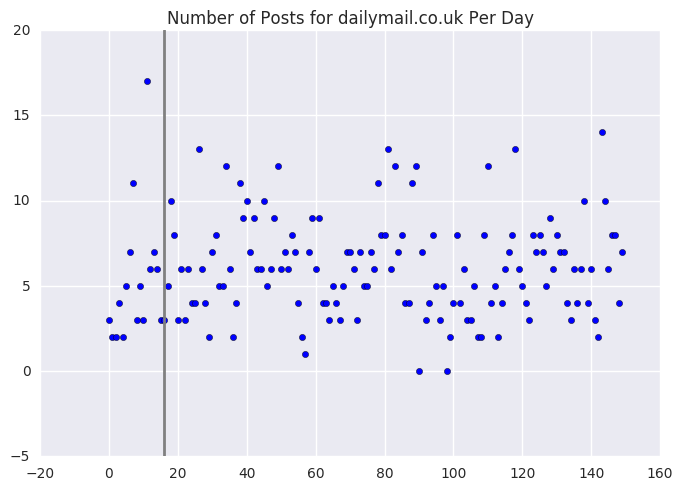

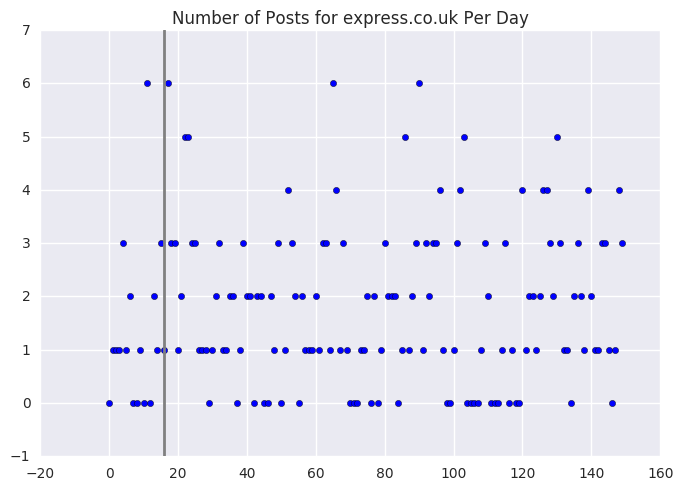

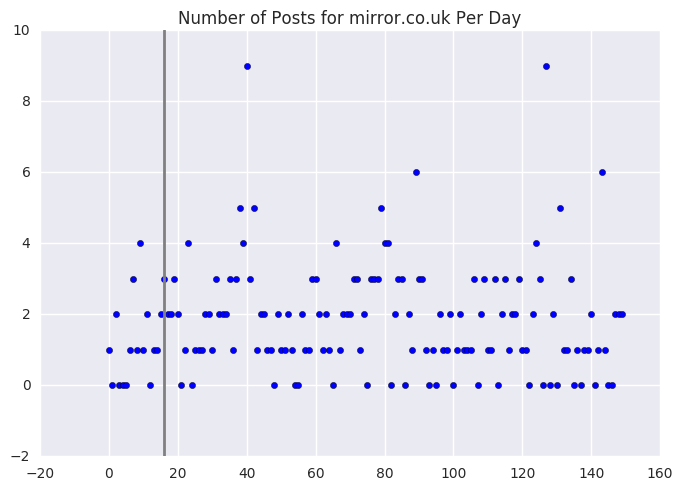

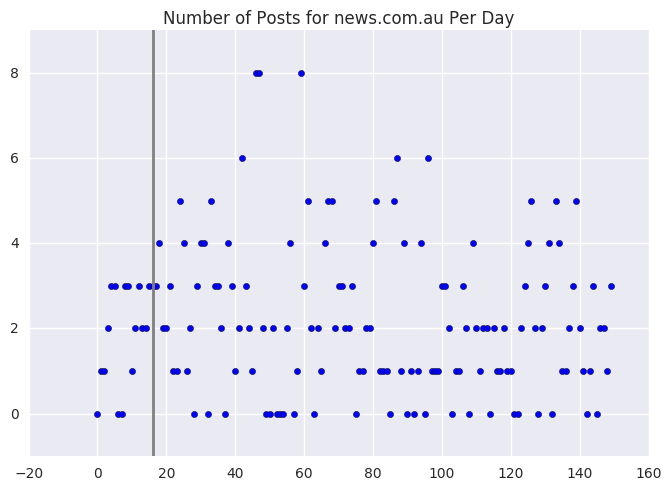

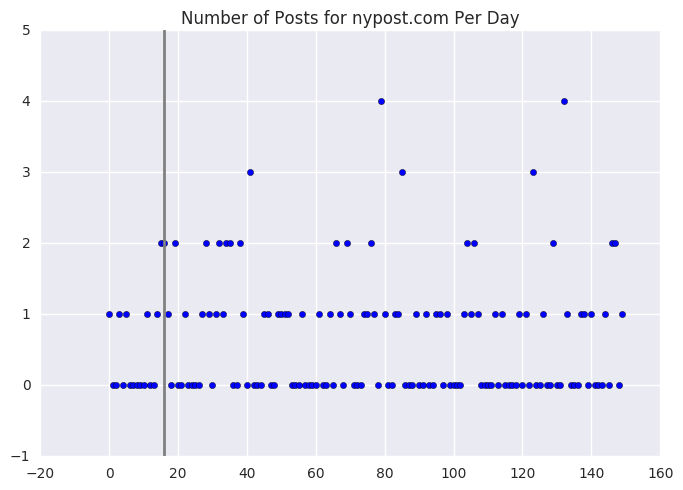

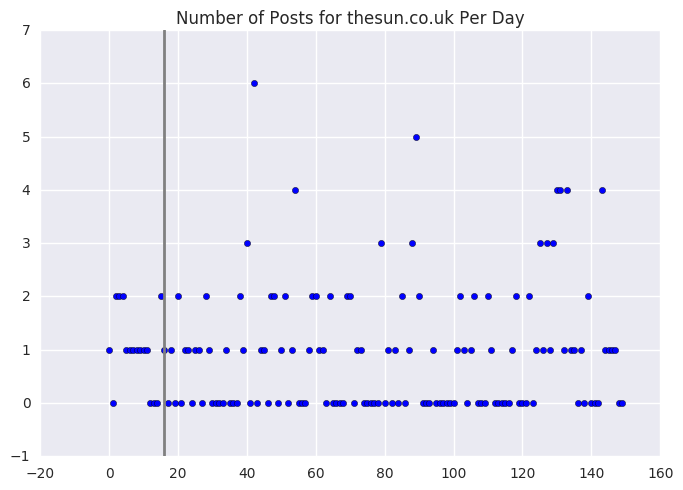

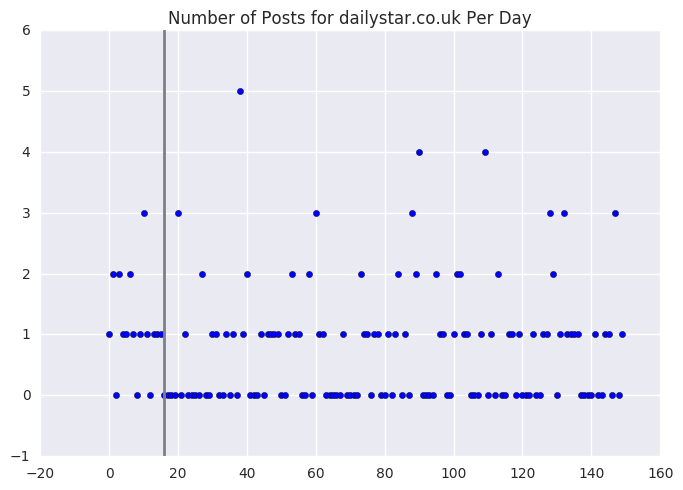

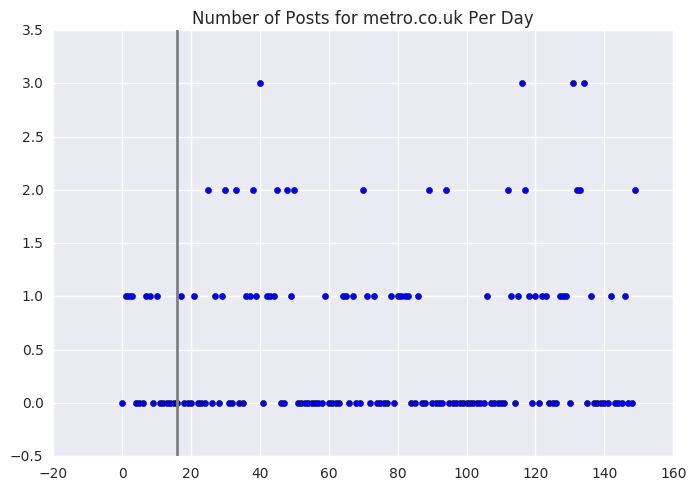

In [14]:
for domain in tabloid_domains:
    plot_vals = [(x['day'], x['total_domain'][domain]) for x in post_days.values()]
    plt.axvline(x=exp_day-min_day, ymin=0, ymax = 1, linewidth=2, color='grey')
    plt.scatter([x[0] for x in plot_vals], [x[1] for x in plot_vals])
    plt.title("Number of Posts for {0} Per Day".format(domain))
    plt.show()

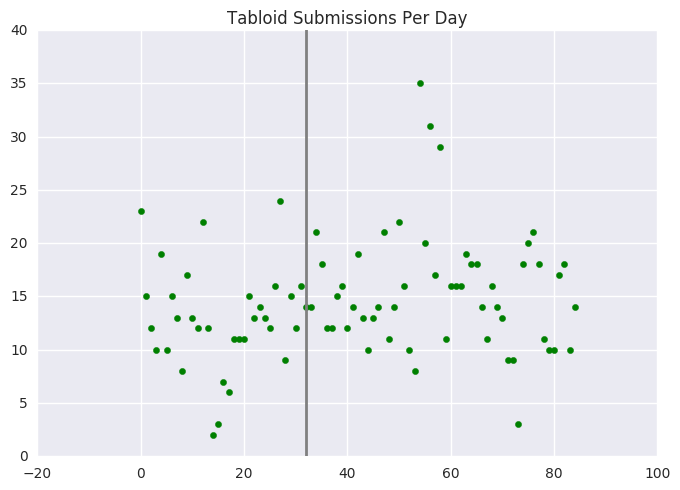

In [44]:
plt.axvline(x=exp_day-min_day, ymin=0, ymax = 100, linewidth=2, color='grey')
#plt.scatter(day_df.day, day_df.total)
#plt.scatter(day_df.day, day_df.msm, color="red")
plt.scatter(day_df.day, day_df.tabloid, color="green")
plt.title("Tabloid Submissions Per Day")
plt.show()

In [ ]:
day_df[day_df.tabloid]

### Analyze Tabloid Rates in the Rankings

In [247]:
def timediff_minutes(timediff):
    return timediff.seconds/60 + timediff.days*1440

post_rankings = defaultdict(list)

ranking_pages = []

for page in db_engine.execute(text("select * from subreddit_pages WHERE subreddit_id='2qh13' AND page_type={0} AND created_at > '{1}' AND created_at < '{2}';".format(
    4, #PageType.HOT
    "2016-11-13",
    experiment_date
))):
    posts = json.loads(page['page_data'])
    median_score = np.median([x['score'] for x in posts])
    post_ages = []
    
    
    for post in posts:
        
        try:
            age = page.created_at - all_posts[post['id']]['created']
        except:
            
            submission = r.get_submission(submission_id = post['id'])
            all_posts[post['id']] = submission.json_dict
            if(submission):
                age = page.created_at - datetime.datetime.utcfromtimestamp(submission.created_utc)
            else:
                age = None
        post_ages.append(timediff_minutes(age))
    
    ### FOR NOW OMIT MEDIAN AGE IF THERE'S MISSING INFO
    try:
        median_age = np.median(post_ages)
    except:
        median_age = None
    position = 0

    ranking = []

    for post in posts:
        try:
            full_post = all_posts[post['id']]
            tabloid = full_post['domain'] in tabloid_domains
            msm = full_post['domain'] in msm_domains
            age = timediff_minutes(page.created_at - full_post['created'])
        except:
            age = None
            msm = None
            tabloid = None
        snapshot = {"created_at":page.created_at,
                    "snapshot.length":len(posts),
                    "position":position,
                    "median.score":median_score,
                    "median.age":median_age,
                    "post.score":post['score'],
                    "post.age": age,
                    "snapshot.comments":post['num_comments'],
                    "post.id":post['id'],
                    "tabloid": tabloid,
                    "msm": msm}
        post_rankings[post['id']].append(snapshot)
        ranking.append(snapshot)
        position += 1
    ranking_pages.append(ranking)

In [265]:
tabloid_pct = []
msm_pct = []
for page in ranking_pages:
    if(len(page)==100):
        tabloid_pct.append(len([x for x in page if x['tabloid']]))
        msm_pct.append(len([x for x in page if x['msm']]))

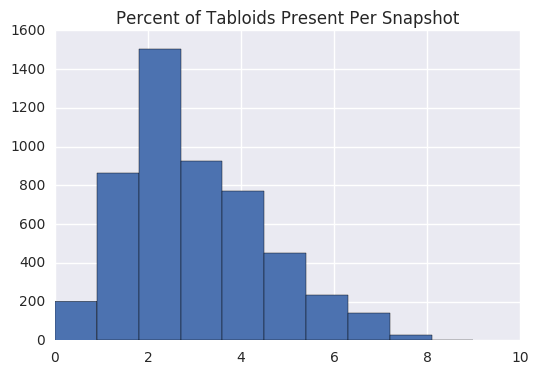

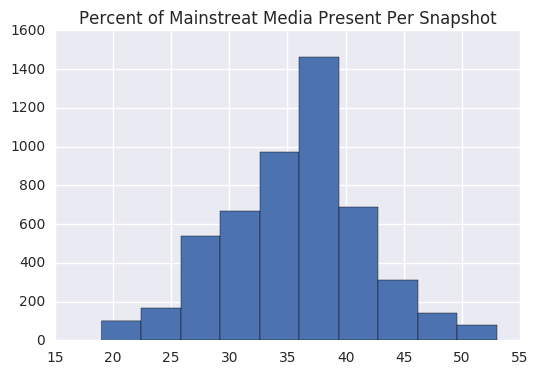

In [266]:
plt.hist(tabloid_pct)
plt.title("Percent of Tabloids Present Per Snapshot")
plt.show()

plt.hist(msm_pct)
plt.title("Percent of Mainstreat Media Present Per Snapshot")
plt.show()

In [280]:
print("Tabloid Ranking Percent: {0}".format(np.mean(tabloid_pct)))
print("Tabloid Percent of Submission: {0}".format(day_df.tabloid_kept_pct.mean()*100))

Tabloid Ranking Percent: 2.855831217034577
Tabloid Percent of Submission: 2.2610529295235477


In [286]:
print(day_df.total.describe())
print((day_df.total_retained / day_df.total).describe())

count     73.000000
mean     446.821918
std       96.004679
min      220.000000
25%      380.000000
50%      447.000000
75%      488.000000
max      724.000000
Name: total, dtype: float64
count    73.000000
mean      0.679319
std       0.076171
min       0.478495
25%       0.639659
50%       0.680743
75%       0.723810
max       0.895623
dtype: float64


### Generate Percentages for Discussion

In [293]:
all_domains = [x['domain'] for x in list(all_posts.values()) if("visible" in x.keys() and x['visible'])]
Counter([x.find("foxnews.com")>-1 for x in all_domains])

Counter({False: 21960, True: 241})

In [295]:
all_domains = [x['domain'] for x in list(all_posts.values()) if("visible" in x.keys() and x['visible'])]
Counter([x.find("rt.com")>-1 for x in all_domains])

Counter({False: 21570, True: 631})

In [296]:
print(241/(21960+241))
241/(21960+241)

0.010855366875365974